In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tfrecord.torch.dataset import MultiTFRecordDataset
from torch.utils.data import Dataset, DataLoader
import os
from os import path as osp

from torch.utils.data import IterableDataset
from fuel_embedding.utils import load
import matplotlib.pyplot as plt
import deepdish as dd
import numpy as np

import trainer as tt

In [13]:
dir11 = 'model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh11_/1'
dir15 = 'model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh15_/1'
dir17 = 'model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh17_/1'

In [46]:
dir = 'model_experiments/new_features_equiv/bs128_esTrue_esS10_pat3_lr0.0001_gamma0.1_drp0.1_nAtt0_inCh12_/1'

evaluator = tt.Evaluator(None,None,dirname = dir15)

Loading 'simple_equiv_encoder' from /Users/gorg/Documents/ndws/model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh15_/1/simple_equiv_encoder.py
Loading 'ndws_data_config' from /Users/gorg/Documents/ndws/model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh15_/1/ndws_data_config.py
Model loaded from model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh15_/1


In [47]:
evaluator.perform_inference(regen = False)

ValueError: Predictions or labels file already exists

In [48]:
evaluator.firemask_file

'model_experiments/simple_encoder/bs128_esTrue_esS10_pat5_lr0.0001_gamma2_lSp0.001_drp0.1_nAtt0_inCh15_/1/firemasks.h5'

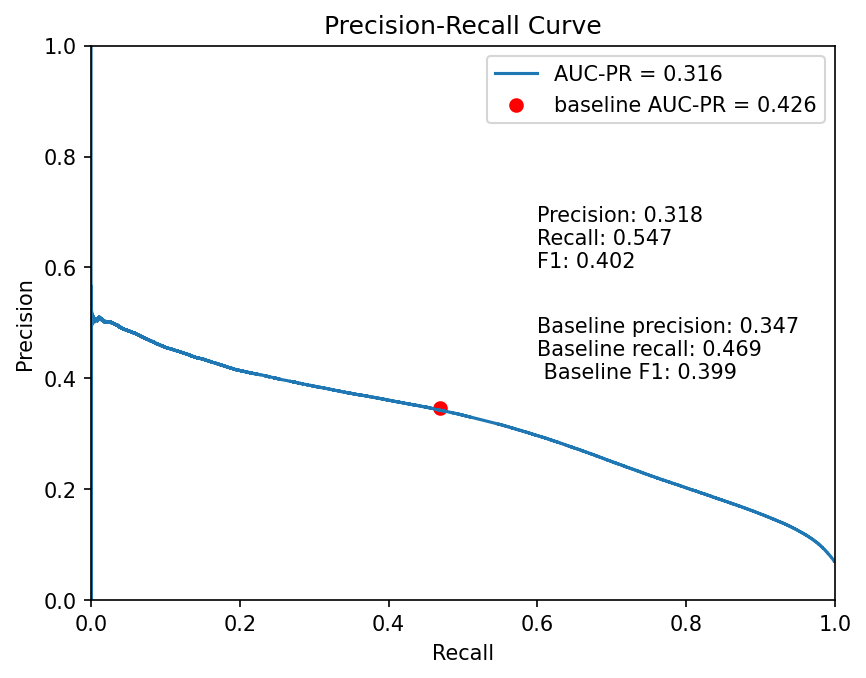

In [49]:
evaluator.evaluate_pr()

/Users/gorg/Documents/ndws/trainer.py:43: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


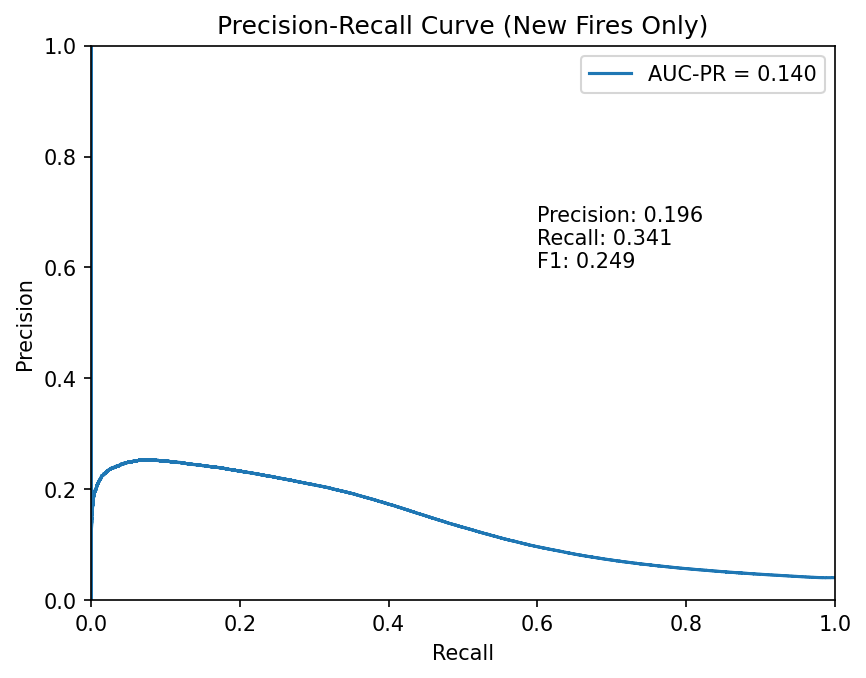

In [36]:
evaluator.evaluate_pr_newOnly()

In [7]:
evaluator.generate_sample()

Sample data saved to: model_experiments/new_features_equiv/bs128_esTrue_esS10_pat8_lr0.0001_gamma0.1_drp0.1_nAtt0_inCh18_/1/sample_data.h5


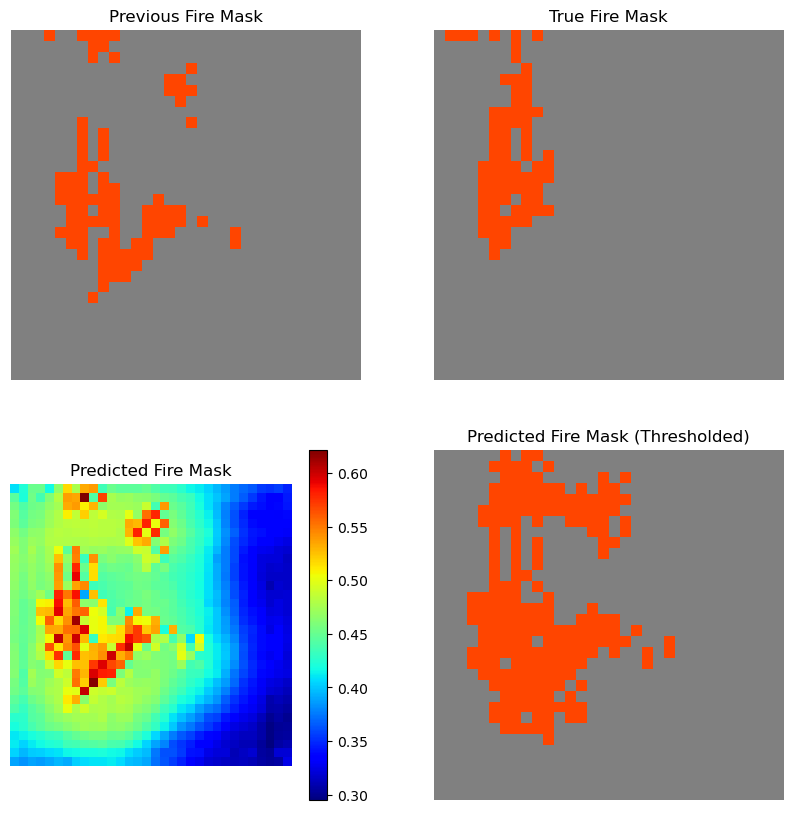

In [95]:
evaluator.plot_sample(idx = 40)

### Visualize effect of wind on fire movement

In [85]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['grey', 'orangered']
n_bins = 256  # Number of color gradients
fire_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
colors = ['grey', 'black']
n_bins = 256  # Number of color gradients
old_cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

In [86]:
sample = dd.io.load(evaluator.sample_file)
    
features = evaluator.config['features']
wind_speed = 'wind_avg'
wind_dir = 'wdir_wind'

stats_file = 'data_statistics/ndws_western_train_stats.h5'
stats = dd.io.load(stats_file)

wind_stats = stats[wind_speed]
wdir_stats = stats[wind_dir]

wind_idx = features.index(wind_speed)
wdir_idx = features.index(wind_dir)

wind_data = sample['data'][:,wind_idx,...]*np.sqrt(wind_stats['var']) + wind_stats['mean']
wdir_data = sample['data'][:,wdir_idx,...]*np.sqrt(wdir_stats['var']) + wdir_stats['mean']

summed = torch.einsum('abc->a',wind_data)
args = np.argsort(summed).flip(dims = [0])

wind = np.array(wind_data[args,...])
wdir = np.array(wdir_data[args,...])

In [89]:
wdir[0]

array([[1.6439, 1.6636, 1.6822, ..., 1.6301, 1.6593, 1.6974],
       [1.6175, 1.6355, 1.6524, ..., 1.5911, 1.6212, 1.6602],
       [1.5922, 1.6084, 1.6236, ..., 1.5524, 1.5834, 1.623 ],
       ...,
       [1.1073, 1.097 , 1.088 , ..., 1.3261, 1.3255, 1.3229],
       [1.0987, 1.0892, 1.081 , ..., 1.3269, 1.3242, 1.3193],
       [1.0914, 1.083 , 1.0758, ..., 1.3231, 1.3186, 1.3115]], dtype=float32)

In [100]:
def create_streamplot(magnitude, angle, ax = ax):
    # Create coordinate grid
    y, x = np.mgrid[0:32, 0:32]
    
    # Convert polar to cartesian components
    U = magnitude * np.cos(angle)  # x-component
    V = magnitude * np.sin(angle)  # y-component
    
    # Create the plot
    # fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize magnitude for linewidth scaling
    # Add a small constant to avoid division by zero
    lw = 3 * magnitude / (magnitude.max().item() + 1e-10)
    
    # Create streamplot with varying linewidth
    ax.streamplot(x, y, -U, -V, 
                 # density=2,
                 color='black',
                 linewidth=lw)
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Set limits and labels
    # ax.set_xlim(0, 31)
    # ax.set_ylim(0, 31)
    
    return fig, ax

In [101]:
sample['data'].shape

torch.Size([256, 15, 32, 32])

In [102]:
arg

tensor(40)

(-0.5, 31.5, 31.5, -0.5)

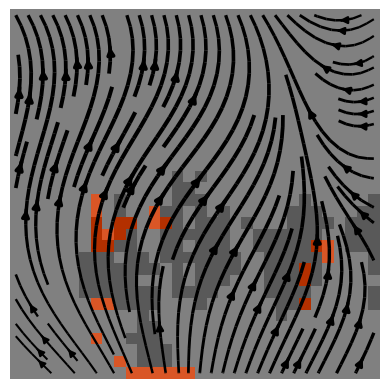

In [113]:
ii = 10
arg = args[ii]
ex_data = sample['data'][arg]
ex_label = sample['label'][arg]
ex_pred = sample['pred'][arg].squeeze(0)
fig,ax = plt.subplots()
create_streamplot(wind[ii],wdir[ii],ax = ax)
ax.imshow(ex_label,cmap = fire_cmap)
ax.imshow(ex_data[-1,...],cmap = old_cmap,alpha = 0.3)
ax.axis('off')

(-0.5, 31.5, 31.5, -0.5)

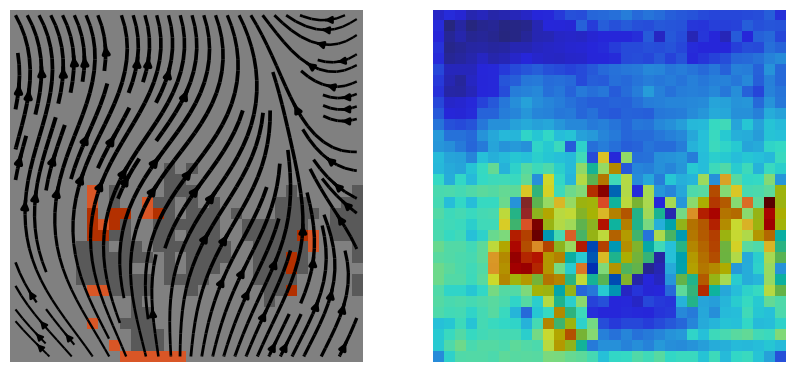

In [114]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
create_streamplot(wind[ii],wdir[ii],ax = ax[0])
ax[0].imshow(ex_label,cmap = fire_cmap)
ax[0].imshow(ex_data[-1,...],cmap = old_cmap,alpha = 0.3)
ax[0].axis('off')

ax[1].imshow(ex_pred,cmap = 'jet')
ax[1].imshow(ex_data[-1,...],cmap = old_cmap,alpha = 0.3)

ax[1].axis('off')

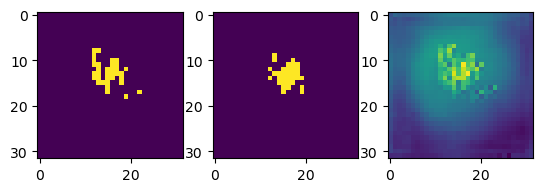

In [106]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(ex_data[-1,...])
ax[1].imshow(ex_label)
ax[2].imshow(ex_pred)